## EDA

### Analysis & Cleaning of Numerical Features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

In [657]:
df= pd.read_csv('data/amazon.csv', nrows=1000)
print(df.shape)

(1000, 16)


In [7]:
df.head()

In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1000 non-null   object 
 1   product_name         1000 non-null   object 
 2   category             1000 non-null   object 
 3   discounted_price     1000 non-null   object 
 4   actual_price         1000 non-null   float64
 5   discount_percentage  1000 non-null   float64
 6   rating               1000 non-null   float64
 7   rating_count         998 non-null    object 
 8   about_product        1000 non-null   object 
 9   user_id              1000 non-null   object 
 10  user_name            1000 non-null   object 
 11  review_id            1000 non-null   object 
 12  review_title         1000 non-null   object 
 13  review_content       1000 non-null   object 
 14  img_link             1000 non-null   object 
 15  product_link         1000 non-null   ob

In [669]:
num_feat_clean= ['discounted_price', 'actual_price', 'discount_percentage', 'rating_count']

In [670]:
# clean numerical features
for i in num_feat_clean:
    df[i]= df[i].apply(lambda x:str(x))
    df[i]= df[i].apply(lambda x:x.replace('₹', ''))
    df[i]= df[i].apply(lambda x:x.replace('%', ''))
    df[i]= df[i].apply(lambda x:x.replace('.', ','))
    df[i]= df[i].apply(lambda x:x.split(',')[:2])
    df[i]= df[i].apply(lambda x: '%s' % ','.join(x))
    df[i]= df[i].apply(lambda x: float(x.replace(',', '.')))

In [6]:
df.loc[df['rating_count'].isnull()]

product_id                                       product_name                                           category  discounted_price  actual_price  discount_percentage  rating  rating_count                                      about_product                       user_id    user_name      review_id                                  review_title                                     review_content                                           img_link  \
282  B0B94JPY2N  Amazon Brand - Solimo 65W Fast Charging Braide...  Computers&Accessories|Accessories&Peripherals|...             199.0         999.0                 80.0     3.0           NaN  USB C to C Cable: This cable has type C connec...  AE7CFHY23VAJT2FI4NZKKP6GS2UQ       Pranav   RUB7U91HVZ30  The cable works but is not 65W as advertised  I have a pd supported car charger and I bought...  https://m.media-amazon.com/images/W/WEBP_40237...   
324  B0BQRJ3C47  REDTECH USB-C to Lightning Cable 3.3FT, [Apple...  Computers&Accessories|Accessories&Peripherals|...             249.0         999.0                 75.0     5.0           NaN  💎[The Fastest Charge] - This iPhone USB C cabl...  AGJC5O5H5BBXWUV7WRIEIOOR3TVQ  Abdul Gafur  RQXD5SAMMPC6L                               Awesome Product  Quick delivery.Awesome ProductPacking was good...  https://m.media-amazon.com/images/I/31-q0xhaTA...   

                                          product_link  
282  https://www.amazon.in/Amazon-Brand-Charging-Su...  
324  https://www.amazon.in/REDTECH-Lightning-Certif...

In [107]:
# introduce median in describe
def describe(df, stats):
    d= df.describe()
    return d.append(df.reindex(d.columns, axis=1).agg(stats))

In [108]:
describe(df, ['median']).T

count        mean         std    min       25%       50%      75%    max    median
discounted_price     1000.0  247.825838  265.916909  1.049   8.99900  198.5000  379.000  999.0  198.5000
actual_price         1000.0  276.108694  359.303527  1.000   2.76725   21.4945  499.000  999.0   21.4945
discount_percentage  1000.0   50.825000   22.227560  0.000  35.00000   55.0000   67.000   94.0   55.0000
rating               1000.0    4.122200    0.267430  2.800   4.00000    4.2000    4.300    5.0    4.2000
rating_count          998.0   79.494826  176.344813  1.001   4.42650   14.1845   38.879  989.0   14.1845

### Analysis & Cleaning of Product Categorical Features

In [20]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud

In [6]:
#df['product_name'][:10].values

In [110]:
df['brand']= df['product_name'].str.split().str[0]

In [300]:
df['product_name'].str.split()

0      [Wayona, Nylon, Braided, USB, to, Lightning, F...
1      [Ambrane, Unbreakable, 60W, /, 3A, Fast, Charg...
2      [Sounce, Fast, Phone, Charging, Cable, &, Data...
3      [boAt, Deuce, USB, 300, 2, in, 1, Type-C, &, M...
4      [Portronics, Konnect, L, 1.2M, Fast, Charging,...
                             ...                        
995    [HP, K500F, Backlit, Membrane, Wired, Gaming, ...
996    [GIZGA, Club-laptop, Neoprene, Reversible, for...
997    [Inventis, 5V, 1.2W, Portable, Flexible, USB, ...
998    [TP-Link, TL-WA855RE, 300, Mbps, Wi-Fi, Range,...
999    [boAt, Stone, 250, Portable, Wireless, Speaker...
Name: product_name, Length: 1000, dtype: object

In [655]:
df_brand= df[df.groupby('brand')['brand'].transform('size') >=5].sort_values(by='brand', ascending=False)

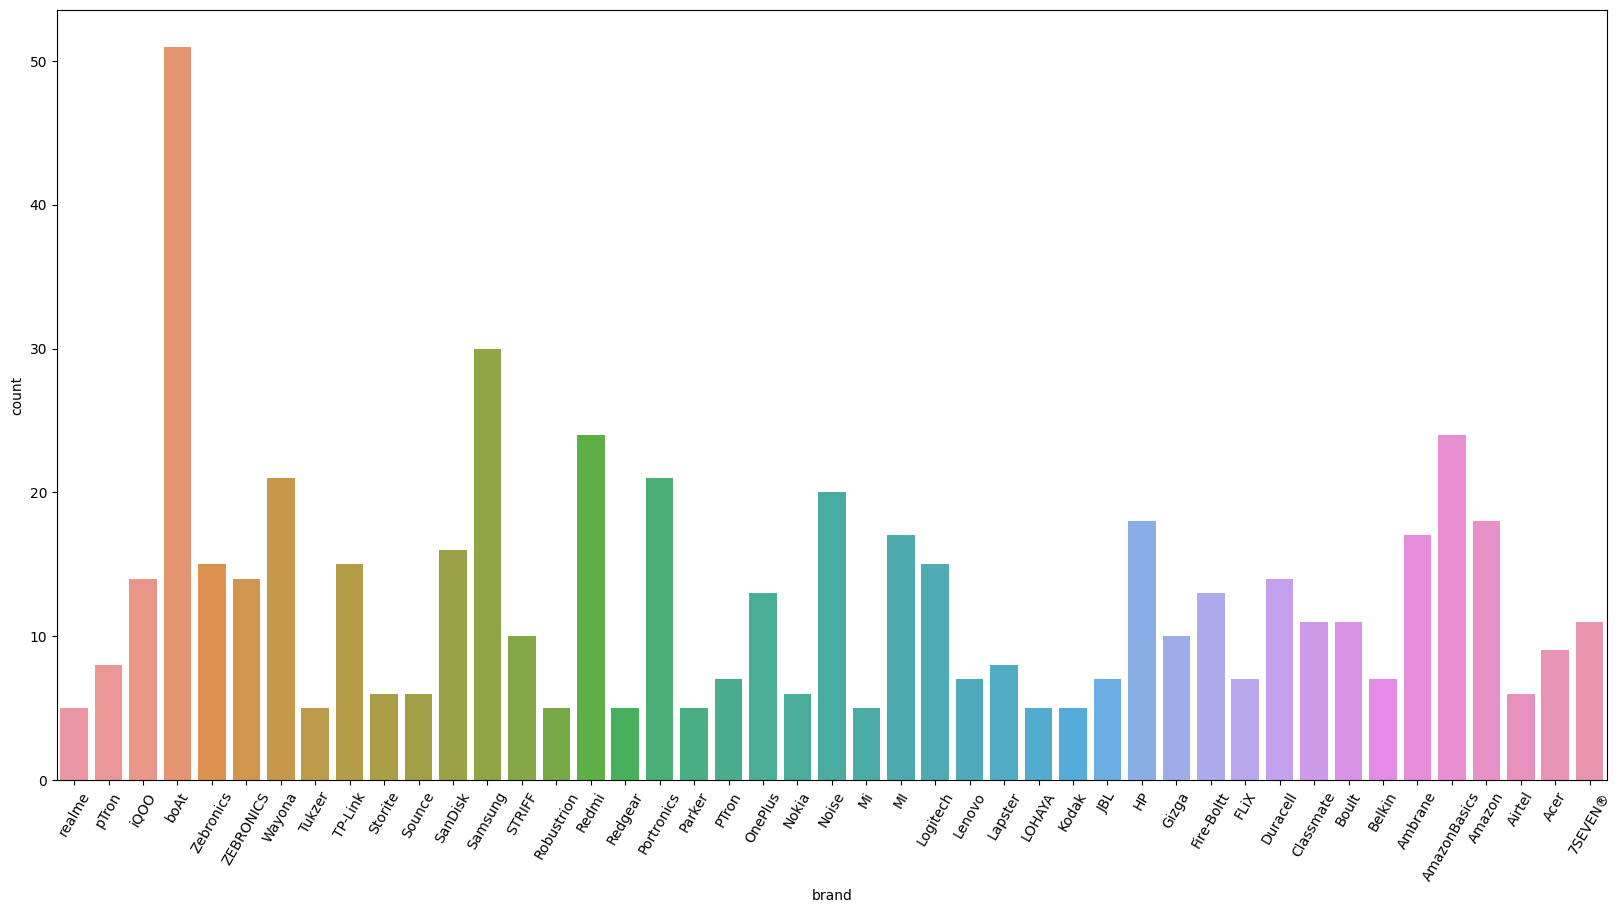

In [656]:
plt.figure(figsize=(20,10))
sns.countplot(df_brand.brand)
plt.xticks(rotation=60)
plt.show();

<AxesSubplot:ylabel='Frequency'>

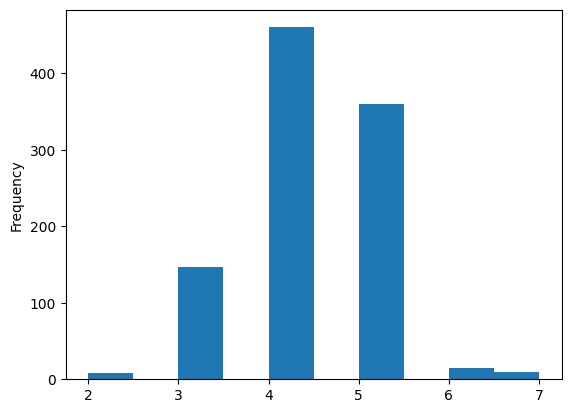

In [387]:
df['category'].str.split('|').apply(lambda x:len(x)).plot(kind='hist')

In [111]:
#df['category'][:2].str.replace('&',' ').str.replace('|',' ').values
df['main_category']= df['category'].str.split('|').str[0]

In [12]:
df.main_category.unique()

array(['Computers&Accessories', 'Electronics', 'MusicalInstruments',
       'OfficeProducts', 'Home&Kitchen', 'HomeImprovement', 'Toys&Games'],
      dtype=object)

In [112]:
df['main_category']= df['main_category'].str.replace('&',' ')
df['main_category']= df['main_category'].str.replace('MusicalInstruments','Musical Instruments')
df['main_category']= df['main_category'].str.replace('OfficeProducts','Office Products')
df['main_category']= df['main_category'].str.replace('HomeImprovement','Home Improvement')

In [113]:
df['sub_category']= df['category'].str.split('|').str[-1]

In [17]:
df.main_category.value_counts()

Electronics              520
Computers Accessories    440
Office Products           28
Home Kitchen               7
Musical Instruments        2
Home Improvement           2
Toys Games                 1
Name: main_category, dtype: int64

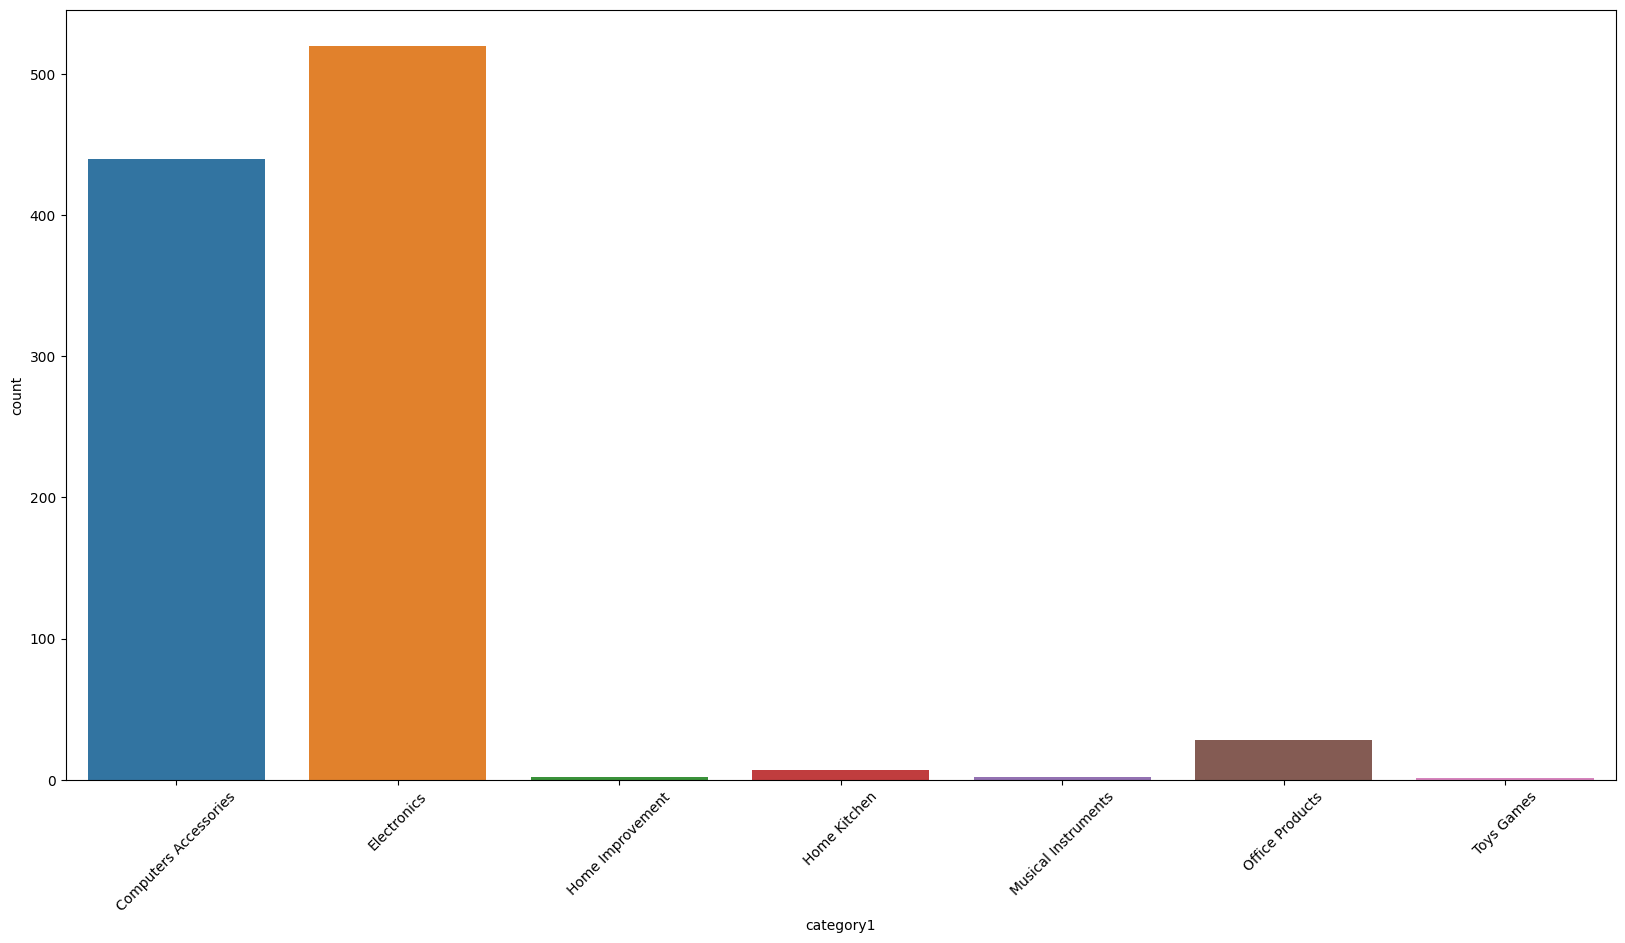

In [441]:
plt.figure(figsize=(20,10))
sns.countplot(df[df.groupby('main_category')['main_category'].transform('size')>=1]['main_category']\
              .sort_values(ascending=True))
plt.xticks(rotation=45)
plt.show();

<AxesSubplot:xlabel='main_category'>

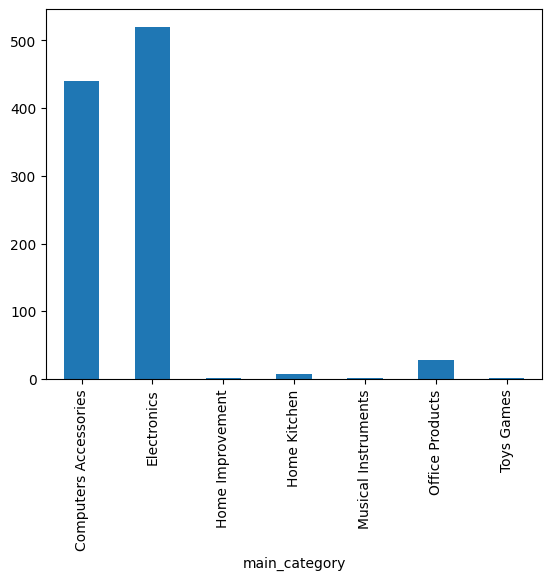

In [38]:
# Another method
df['index']= df.index
df.groupby('main_category').index.count().plot.bar()

In [ ]:
plt.figure(figsize=(22,12))
sns.countplot(df[df.groupby('sub_category')['sub_category'].transform('size')>=1]['sub_category']\
              .sort_values(ascending=True))
plt.xticks(rotation=90)
plt.show();

In [559]:
# About the product column
#df['about_product'][:5].values

Text(0.5, 1.0, 'length of product description in the corpus')

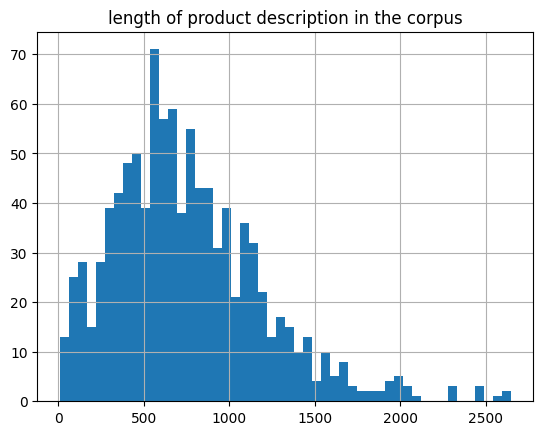

In [661]:
# visualize the length of product description
df['about_product'].str.len().hist(bins=50)
plt.title('length of product description in the corpus')

Text(0.5, 1.0, 'length of product description per product')

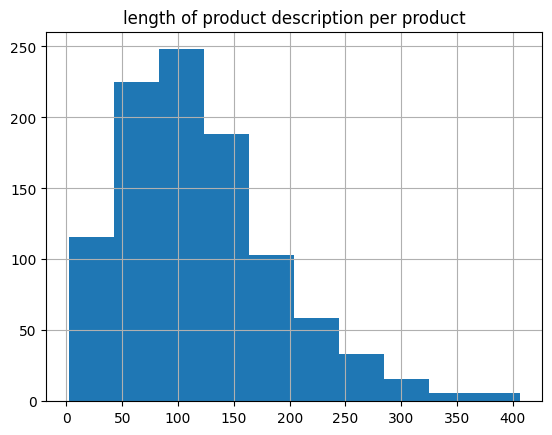

In [662]:
# num words/desc
df['about_product'].str.split().map(lambda x:len(x)).hist()
plt.title('length of product description per product')

In [114]:
# create string for each main category
electronics= ''.join(list(df.about_product[df.main_category=='Electronics']))
computers= ''.join(list(df.about_product[df.main_category=='Computers Accessories']))
office= ''.join(list(df.about_product[df.main_category=='Office Products']))
kitchen= ''.join(list(df.about_product[df.main_category=='Home Kitchen']))

In [62]:
stop_words= stopwords.words('english')

In [115]:
def word_cloud(text, title):
    cloud= WordCloud(width= 1600, height=1000, background_color='white', stopwords= stop_words,\
                    min_font_size=10).generate(text)
    plt.figure(figsize=(16,10), facecolor=None)
    plt.imshow(cloud)
    plt.title(f'Word cloud for category {title}\n', fontsize=20)
    plt.axis('off')
    plt.show();

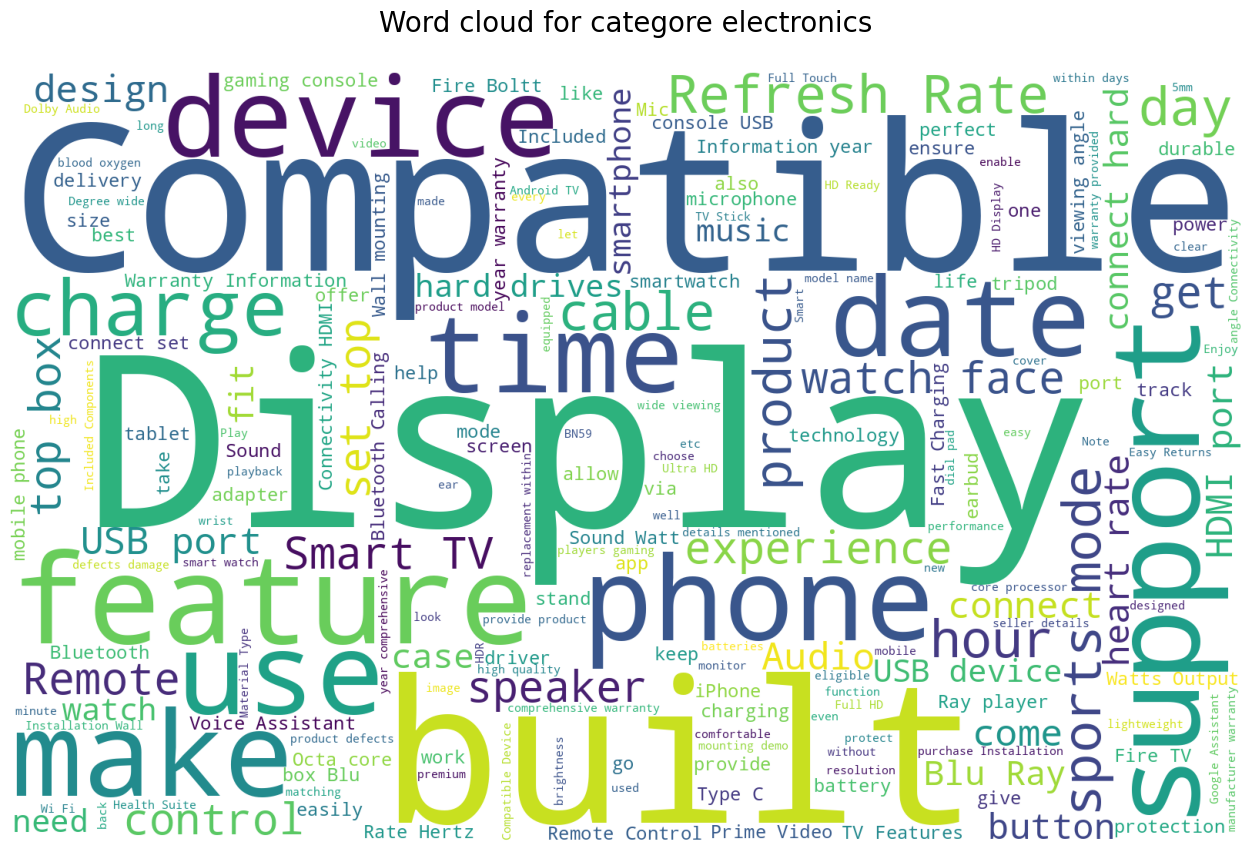

In [21]:
word_cloud(electronics, 'electronics')

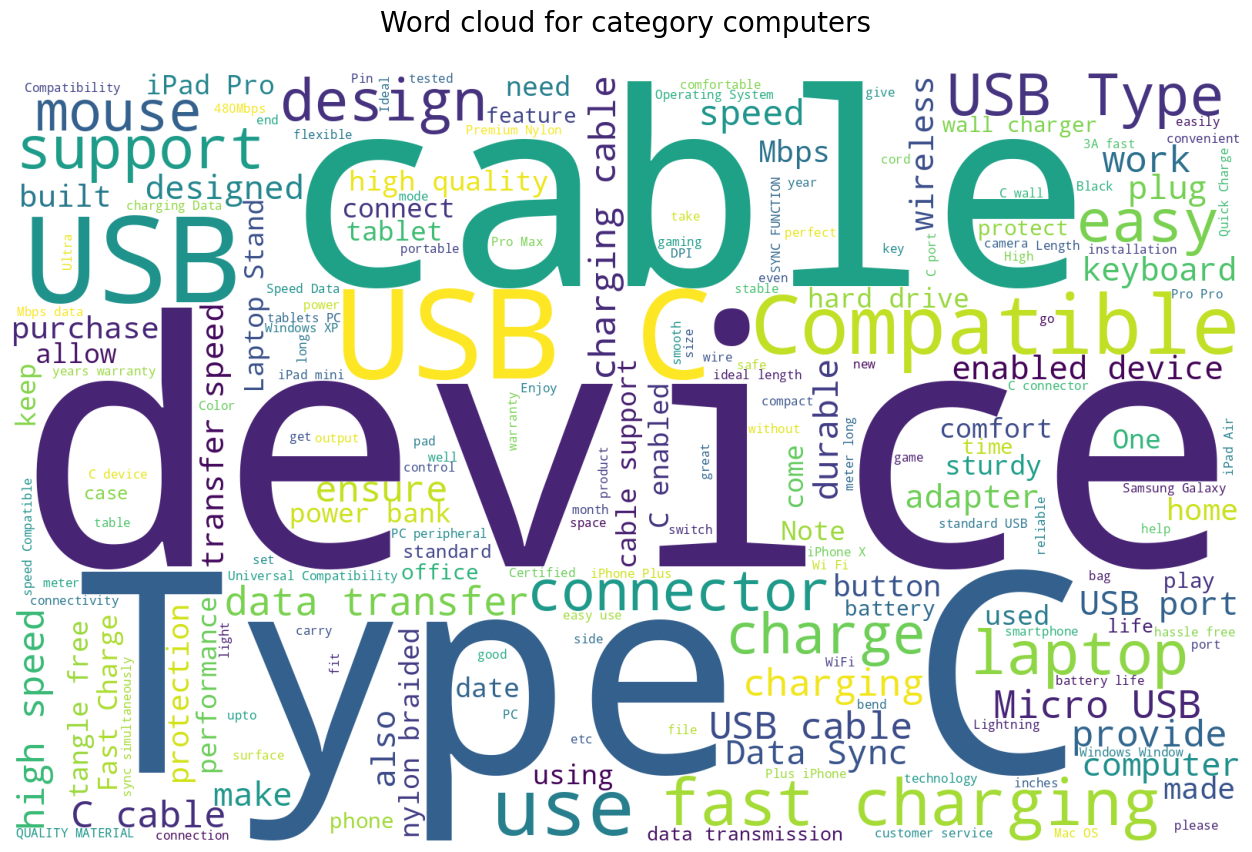

In [24]:
word_cloud(computers, 'computers')

In [28]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [78]:
porter= PorterStemmer()

In [194]:
# clean text
def clean_text(text):
    text= text.lower().replace('【','').replace('】','').replace('–','')
    for i in ['🔥','👍', '😃', '😟','⛵','’','❤️']:
        text= text.replace(i,'')
    text= ''.join([char for char in text if not char.isdigit()]) 
    for i in string.punctuation:
        text= text.replace(i, ' ')
    #text_punct= ''.join([char for char in text if char not in string.punctuation])
    words= word_tokenize(text)
    filtered_words= [word for word in words if word not in stop_words]
    stemmed= [porter.stem(word) for word in filtered_words]
    stemmed= ' '.join(stemmed)
    return stemmed.strip()

In [117]:
df['clean_about_product']= df['about_product'].apply(clean_text)

In [663]:
#df.about_product[:2].values

In [560]:
#df.clean_about_product[:2].values

### Tf-Idf Vectorization

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD,PCA

In [74]:
len(df.main_category.unique())

7

In [175]:
df['main_category_id']= df.main_category.factorize()[0]

In [183]:
# better to set max_features= 100, 150, 200, 250
tfidf= TfidfVectorizer(sublinear_tf=True, max_features=300, ngram_range=(1,2),norm='l2')
X= tfidf.fit_transform(df.clean_about_product).toarray()
y= df['main_category_id']

In [184]:
X.shape, y.shape

((1000, 300), (1000,))

In [81]:
y.value_counts()

1    520
0    440
3     28
4      7
2      2
5      2
6      1
Name: main_category_id, dtype: int64

In [185]:
df_cat_id= df[['main_category_id', 'main_category']].drop_duplicates().sort_values(by='main_category_id',ascending=True)\
.reset_index(drop=True)

In [167]:
df_cat_id

main_category_id          main_category
0                 0  Computers Accessories
1                 1            Electronics
2                 2    Musical Instruments
3                 3        Office Products
4                 4           Home Kitchen
5                 5       Home Improvement
6                 6             Toys Games

In [179]:
cat_to_id= dict(df_cat_id.values)
cat_to_id

{0: 'Computers Accessories',
 1: 'Electronics',
 2: 'Musical Instruments',
 3: 'Office Products',
 4: 'Home Kitchen',
 5: 'Home Improvement',
 6: 'Toys Games'}

In [186]:
N=6
for idx, cat in sorted(cat_to_id.items()):
    #print(f'{idx} - {cat}')
    chi2_feat= chi2(X, y== idx)
    indices= np.argsort(chi2_feat[0])
    names_feat= np.array(tfidf.get_feature_names_out())[indices]
    unigram= [v for v in names_feat if len(v.split(' '))==1]
    bigram= [v for v in names_feat if len(v.split(' '))==2]
    print(f'# {cat}')
    print('-'*40)
    print(f' most correlated words:\n {unigram[-N:]}\n')

# Computers Accessories
----------------------------------------
 most correlated words:
 ['display', 'remot', 'mous', 'usb', 'cabl', 'data']

# Electronics
----------------------------------------
 most correlated words:
 ['hd', 'cabl', 'display', 'tv', 'remot', 'data']

# Musical Instruments
----------------------------------------
 most correlated words:
 ['protector', 'pc', 'adapt', 'audio', 'degre', 'smartphon']

# Office Products
----------------------------------------
 most correlated words:
 ['friendli', 'free', 'colour', 'bodi', 'color', 'cover']

# Home Kitchen
----------------------------------------
 most correlated words:
 ['set', 'standard', 'smooth', 'extra', 'surfac', 'colour']

# Home Improvement
----------------------------------------
 most correlated words:
 ['length', '100', 'adapt', 'size', 'input', 'plug']

# Toys Games
----------------------------------------
 most correlated words:
 ['charg', 'cabl', 'usb', 'color', 'model', 'safe']



In [187]:
sample_size= int(len(X) * 0.30)
np.random.seed(0)
random_idx= np.random.choice(range(len(X)), sample_size, replace=False)
proj_features= TSNE(random_state=0).fit_transform(X[random_idx])

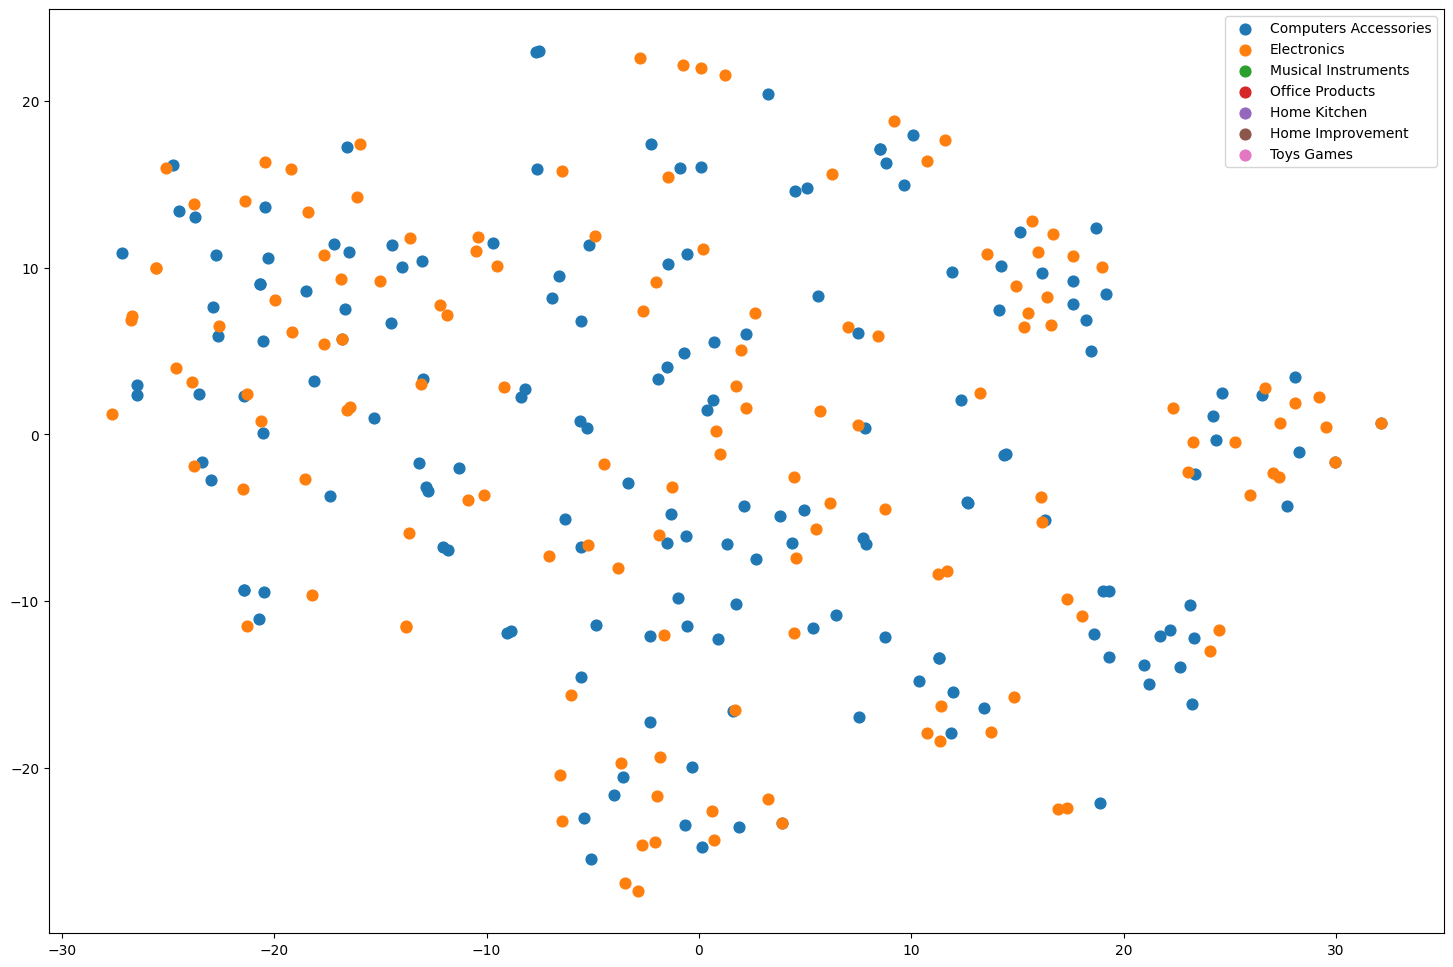

In [190]:
plt.figure(figsize=(18,12))
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey', 'blue', 'brown']
for idx, cat in sorted(cat_to_id.items()):
    points= proj_features[(y[indices]==idx).values]
    plt.scatter(points[:,0], points[:,1], s=60, c= colors[idx], label=cat)

plt.legend(loc='upper right')
plt.show();

### Analysis & Cleaning of Reviews

In [192]:
df.user_name[:5].values

array(['Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jaspreet singh,Khaja moin,Anand,S.ARUMUGAM',
       'ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Placeholder,BharanI,sonia,Niam',
       'Kunal,Himanshu,viswanath,sai niharka,saqib malik,Aashiq,Ramu Challa,Sanjay gupta',
       'Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh chouhan,Ravi Siddan,Himanshu Goel,Udaykumar',
       'rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK,Bhargav,Durai Vignesh,Amazon Customer'],
      dtype=object)

In [5]:
df['category'].str.split('|',expand=True).head(10)

In [4]:
df[['user_id','user_name','review_id']].drop_duplicates()

In [118]:
df_user= df.copy()

In [119]:
df_user['user_id'] =df_user['user_id'].str.split(',', expand=False)
df_user['user_name'] =df_user['user_name'].str.split(',', expand=False)

In [ ]:
df_user_id= df_user.explode(column= 'user_id', ignore_index= True)
df_user_name= df_user.explode(column= 'user_name', ignore_index= True)

In [561]:
#df_user_id.head()

In [ ]:
df_user_id['user_name']= df_user_name.user_name

In [122]:
df_review= df.copy()

In [123]:
df_review['review_id'] =df_review['review_id'].str.split(',', expand=False)
df_review['review_title'] =df_review['review_title'].str.split(',', expand=False)

In [ ]:
df_review_id= df_review.explode(column= 'review_id', ignore_index= True)
df_review_title= df_review.explode(column= 'review_title', ignore_index= True)

In [ ]:
df_review_id['review_title']= df_review_title.review_title

In [ ]:
df_review_id['user_id']= df_user_id.user_id

In [ ]:
df_review_id['user_name']= df_user_id.user_name

In [562]:
#df_review_id.review_title.value_counts()[-50:]

In [142]:
df_review= df_review_id.copy()
#df_review.head()

In [130]:
df_review.duplicated().sum()

0

In [143]:
df_review.review_title= df_review.review_title.apply(clean_text)

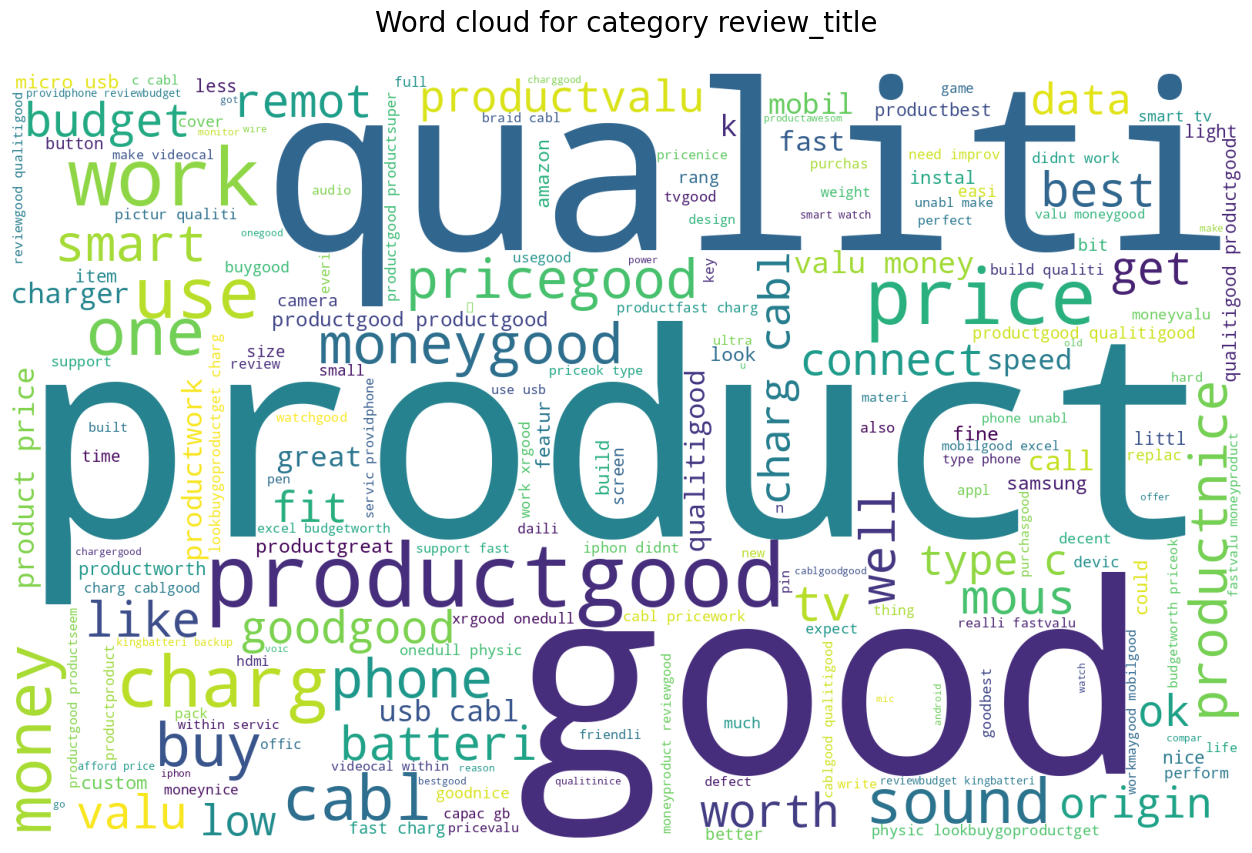

In [145]:
rev_title= ''.join(list(df_review.review_title.values))
word_cloud(rev_title,'review_title')

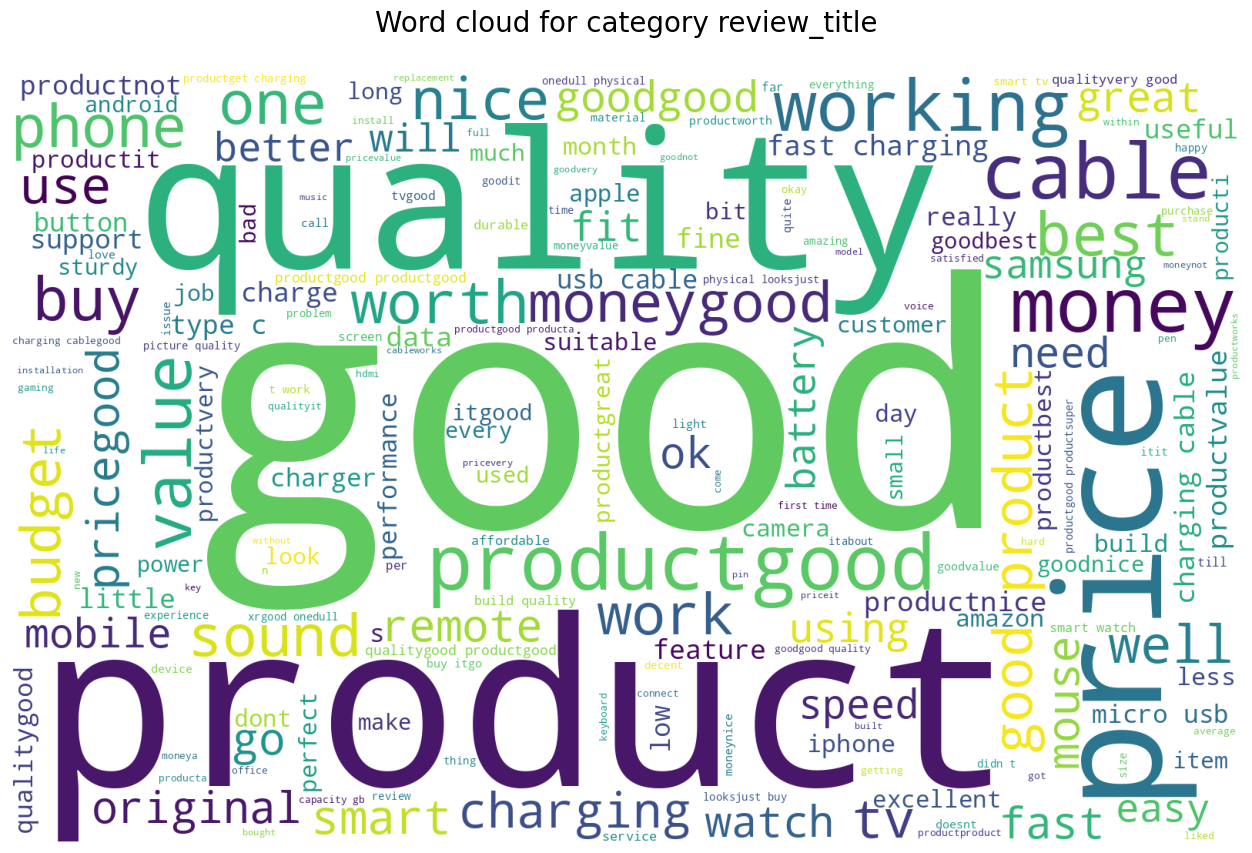

In [386]:
rev_title= ''.join(list(df_review.review_title.values))
word_cloud(rev_title,'review_title')

In [563]:
#df_review.review_content.values[:2]

In [147]:
df_review_cont= df_review.copy()

In [ ]:
df_review_cont['review_content'] =df_review_cont['review_content'].str.split(',', expand=False)
df_review_cont2= df_review_cont.explode(column= 'review_content', ignore_index= True)

In [ ]:
df_review_cont['review_content']= df_review_cont2.review_content

In [152]:
df_review_cont.review_content.values[:5]

array(['Looks durable Charging is fine tooNo complains',
       'Charging is really fast', ' good product.',
       'Till now satisfied with the quality.',
       'This is a good product . The charging speed is slower than the original iPhone cable'],
      dtype=object)

In [150]:
df_review=df_review_cont.copy()

In [153]:
df_review['review_content']= df_review['review_content'].apply(clean_text)

In [154]:
df_review['review_content'].values[:10]

array(['look durabl charg fine toono complain', 'charg realli fast',
       'good product', 'till satisfi qualiti',
       'good product charg speed slower origin iphon cabl',
       'good qualiti', 'would recommend',
       'http media amazon com imag w webp imag fzghl sy jpg',
       'product work well till date issu cabl also sturdi enough ask replac compani',
       'valu money'], dtype=object)

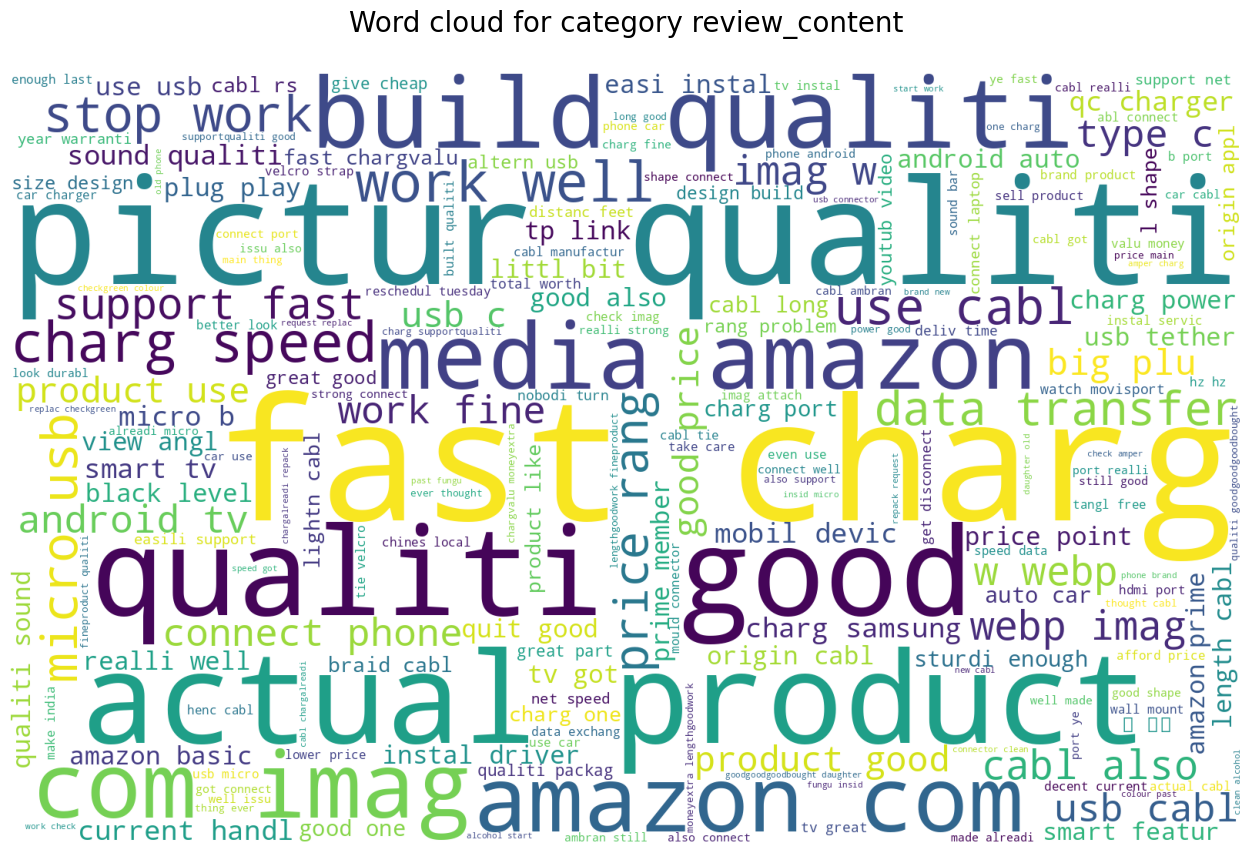

In [155]:
rev_cont= ''.join(list(df_review.review_content.values))
word_cloud(rev_cont,'review_content')

In [156]:
df_review.to_csv('data/df_prepared.csv')

In [87]:
df_review= pd.read_csv('data/df_prepared.csv')

### Outlier Analysis of Numerical Features

In [36]:
num_features= ['discounted_price', 'actual_price', 'discount_percentage','rating', 'rating_count']

In [564]:
# for i in num_features:
#     sns.boxplot(df_review[i])
    # sns.kdeplot(df_review[i])
#     plt.show();

## Feature Engineering & Visualization

In [161]:
df_features= df_review.copy()

In [480]:
pd.DataFrame({'mean': df_features.rating_count.mean(),'mode': df_features.rating_count.mode(),\
             'median': df_features.rating_count.median()})

mean   mode  median
0  80.371324  9.378  14.185

In [167]:
df_features.fillna(df_features.rating_count.mode()[0], inplace=True)

In [169]:
df_featured= df_features.groupby('product_id').agg({'user_id':'count'})\
.rename(columns={'user_id':'order_count'})

In [85]:
num_features= ['discounted_price', 'actual_price', 'discount_percentage','rating', 'rating_count','order_count']

In [465]:
print(df_featured.shape)

(892, 5)


In [170]:
df_feat_merged= df_features.merge(df_featured, on= 'product_id', how= 'left')

Text(0, 0.5, 'count')

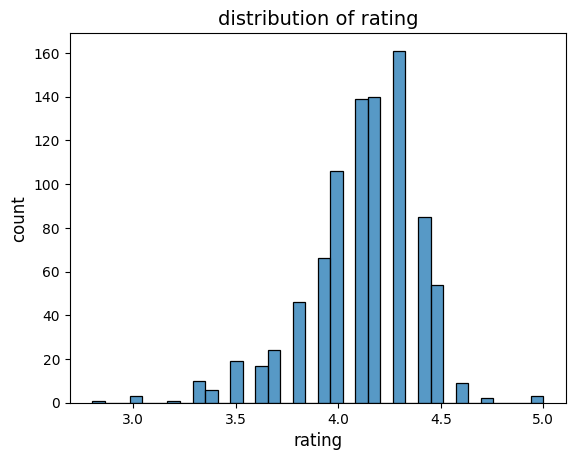

In [684]:
sns.histplot(df_plot.rating.sort_values(ascending=False), kde=False)
plt.title('distribution of rating', fontsize=14)
plt.xlabel('rating', fontsize=12)
plt.ylabel('count', fontsize=12)

<AxesSubplot:xlabel='actual_price', ylabel='discounted_price'>

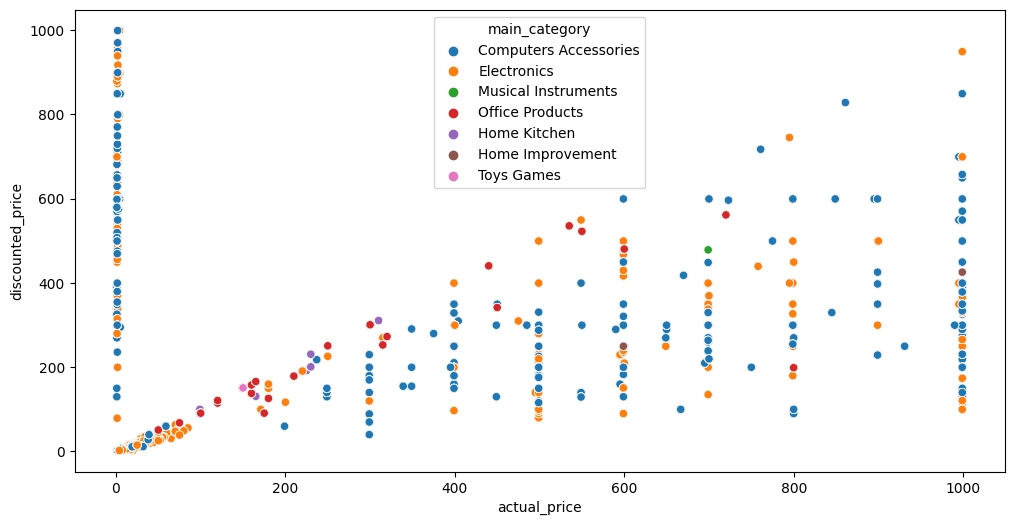

In [499]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='actual_price', y= 'discounted_price', data= df_feat_merged, hue='main_category')

In [173]:
df_feat_merged.to_csv('data/df_feat_merged.csv')

In [72]:
df_feat_merged= pd.read_csv('data/df_feat_merged.csv')

<AxesSubplot:xlabel='rating', ylabel='actual_price'>

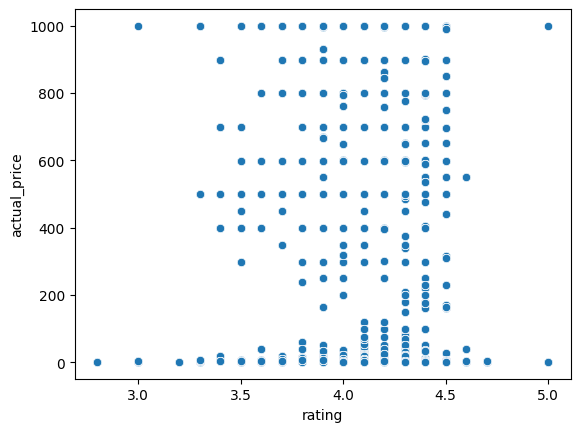

In [32]:
#plt.figure(figsize=(18,12))
#sns.barplot(y='actual_price', x= 'rating', data= df_feat_merged)
sns.scatterplot(y='actual_price', x= 'rating', data= df_feat_merged)

In [565]:
#df_feat_merged[df_feat_merged.actual_price >=999]['rating'].value_counts()

In [672]:
df_plot= df.groupby('product_id').agg({'rating':'mean','discount_percentage':'mean'})

Text(0, 0.5, 'discount_percentage')

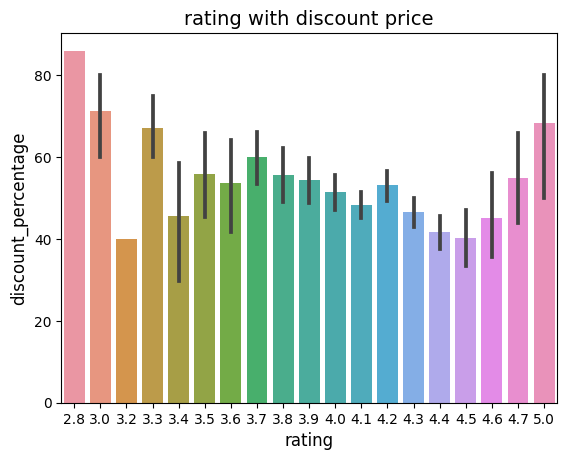

In [685]:
sns.barplot(y='discount_percentage', x= 'rating', data= df_plot)
plt.title('rating with discount price', fontsize=14)
plt.xlabel('rating', fontsize=12)
plt.ylabel('discount_percentage', fontsize=12)

In [202]:
df_review_merge= df_feat_merged.copy()
df_review_merge[['product_id','review_title', 'review_content']].head()

product_id       review_title                                     review_content
0  B07JW9H4J1            satisfi              look durabl charg fine toono complain
1  B07JW9H4J1  charg realli fast                                  charg realli fast
2  B07JW9H4J1         valu money                                       good product
3  B07JW9H4J1     product review                               till satisfi qualiti
4  B07JW9H4J1       good qualiti  good product charg speed slower origin iphon cabl

In [ ]:
merged= pd.DataFrame(df_review_merge.groupby('product_id')['review_title'].apply(lambda x: '%s' % ' '.join(x)))
merged.columns= ['review_title_merged']

In [204]:
df_merged_review= df_review_merge.merge(merged, on='product_id', how='left')

In [207]:
df_merged_review['review_title_content']= df_merged_review[['review_title_merged','review_content']].apply(lambda x: ' '.join(x), axis=1)

In [566]:
#pd.DataFrame(df_merged.groupby('product_id')['review_title_content'])[1][:100]

In [219]:
df_merged= df_merged_review.copy() 

In [238]:
df_merged['review_title_content']= df_merged['review_title_content'].apply(lambda x: x.replace('😅','')\
                                   .replace('❤️','').replace('😊','').replace('♥️','').replace('👌','')\
                                  .replace('🥰','').replace('😜',''))

In [567]:
#df_merged['review_title_content'].values[-100:]

In [250]:
df_merged.to_csv('data/df_merged_clean_emoji')

## Recommendation System

### More Feature Eng

In [21]:
from sklearn.decomposition import TruncatedSVD,PCA

In [355]:
df_recomm= df_merged.copy()

In [356]:
df_recomm1= df_recomm.groupby('brand').agg({'user_id':'count'}).rename(columns={'user_id':'brand_count'})
#df_recomm1

In [357]:
df_recomm_feat=df_recomm.merge(df_recomm1, on='brand',how='left')

In [359]:
df_recomm2= df_recomm_feat.groupby('sub_category').agg({'user_id':'count'}).rename(columns={'user_id':'sub_category_count'})

In [ ]:
df_recomm_feat1=df_recomm_feat.merge(df_recomm2, on='sub_category', how='left')

<AxesSubplot:>

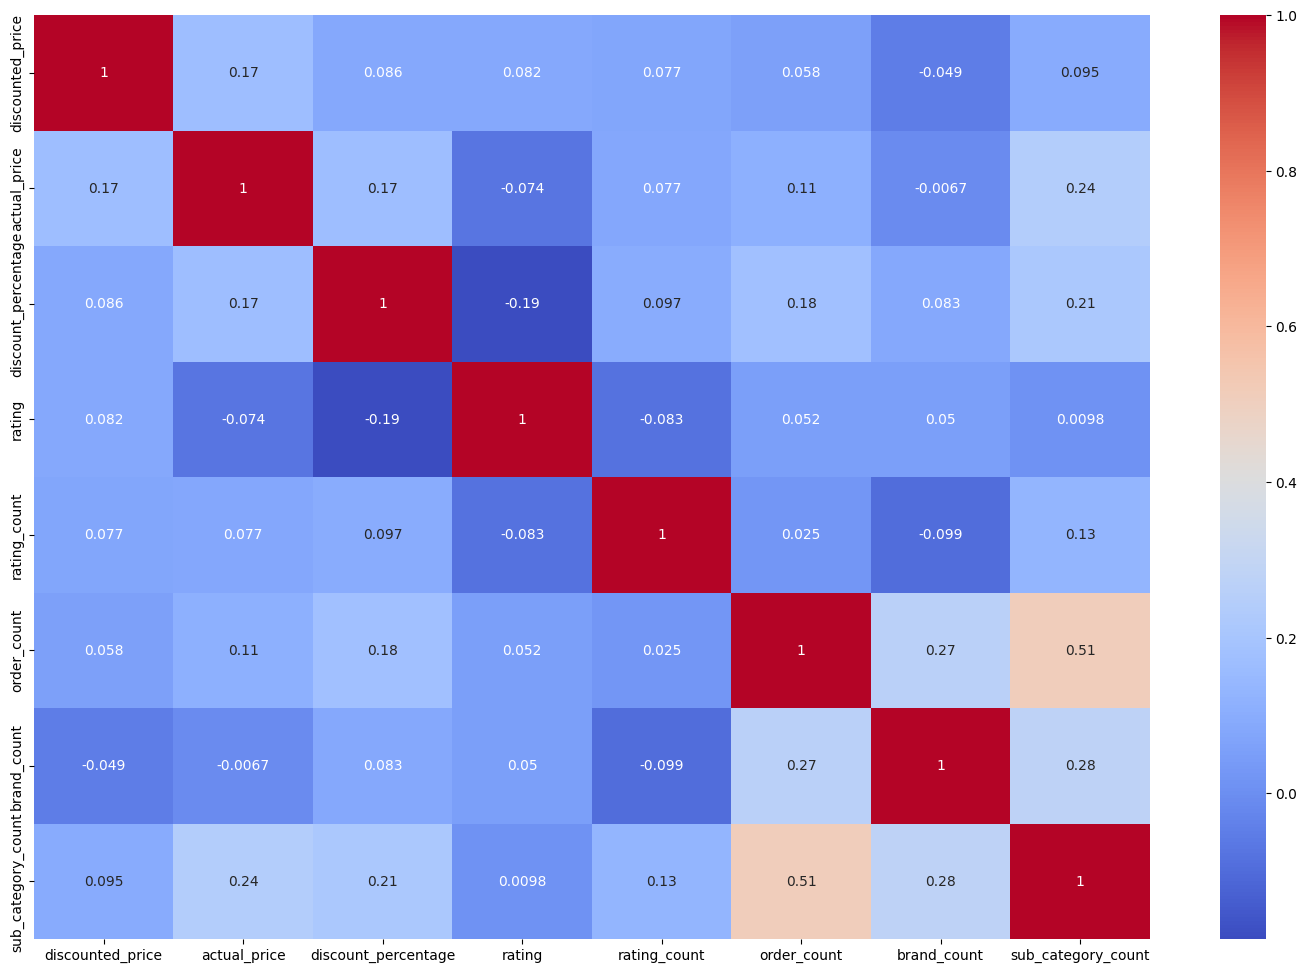

In [367]:
plt.figure(figsize=(18,12))
sns.heatmap(df_recomm_feat1.corr(), annot=True, cmap='coolwarm')

In [370]:
df_recomm_feat1.shape

(7858, 25)

In [371]:
#df_recomm_feat1.to_csv('data/df_merged_clean_emoji')

### Recommendation -- Content

In [65]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics.pairwise import cosine_similarity

In [737]:
df= df_recomm_feat1.copy()

In [119]:
df.shape

(7858, 10)

In [687]:
df= df[['product_name','user_id','product_id','brand','main_category','sub_category', 'clean_about_product', 'actual_price', 'discounted_price','discount_percentage']]

In [688]:
merged= pd.DataFrame(df.groupby('product_id')['user_id'].apply(lambda x:'%s' % ' '.join(x))).rename(columns={'user_id':'user_id_joined'})
df_merged= df.merge(merged, on='product_id', how='left')

In [113]:
df_merged.drop(columns=['user_id'], inplace=True)

In [122]:
df_merged.head()

product_name  product_id       brand          main_category sub_category                                clean_about_product  actual_price  discounted_price  discount_percentage                                     user_id_joined
0  Wayona Nylon Braided USB to Lightning Fast Cha...  B07JW9H4J1      Wayona  Computers Accessories    USBCables  high compat compat iphon x xsmax xr iphon plu ...         1.099             399.0                 64.0  AG3D6O4STAQKAY2UVGEUV46KN35Q AHMY5CWJMMK5BJRBB...
1  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...  B098NS6PVG     Ambrane  Computers Accessories    USBCables  compat type c enabl devic android smartphon mi...       349.000             199.0                 43.0  AECPFYFQVRUWC3KGNLJIOREFP5LQ AGYYVPDD7YG7FYNBX...
2  Sounce Fast Phone Charging Cable & Data Sync U...  B096MSW6CT      Sounce  Computers Accessories    USBCables  fast charger data sync built safeti proctect f...         1.899             199.0                 90.0  AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA AESFLDV2PT363T2AQ...
3  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...  B08HDJ86NZ        boAt  Computers Accessories    USBCables  boat deuc usb cabl compat smartphon tablet pc ...       699.000             329.0                 53.0  AEWAZDZZJLQUYVOVGBEUKSLXHQ5A AG5HTSFRRE6NL3M5S...
4  Portronics Konnect L 1.2M Fast Charging 3A 8 P...  B08CF3B7N1  Portronics  Computers Accessories    USBCables  charg sync function cabl come charg data sync ...       399.000             154.0                 61.0  AE3Q6KSUK5P75D5HFYHCRAOLODSA AFUGIFH5ZAFXRDSZH...

In [570]:
#df_merged.product_name.iloc[9]

In [571]:
#df_merged.product_name.iloc[17]

In [689]:
df_merged.drop_duplicates(inplace=True)

In [120]:
df_merged.shape

(900, 10)

In [121]:
df_merged.reset_index(drop=True, inplace=True)

<AxesSubplot:>

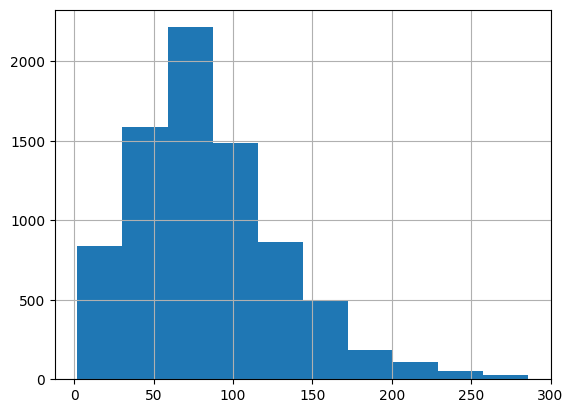

In [591]:
df_recom_cont['clean_about_product'].str.split().map(lambda x:len(x)).hist()

In [690]:
#count= CountVectorizer(stop_words='english', max_features=100)
count= TfidfVectorizer(max_features=200, max_df=0.75, ngram_range=(1,2),norm='l2')
df_count= count.fit_transform(df_merged['clean_about_product'])

In [691]:
df_vector_prod= pd.DataFrame(df_count.toarray(), index= df_merged.index.tolist())

In [724]:
pca_min= pca.explained_variance_ratio_.cumsum().min()

In [728]:
pca.explained_variance_ratio_.cumsum()[79]

0.8030532193265951

In [692]:
#svd= TruncatedSVD()
pca= PCA(n_components=80)
df_cont= pca.fit_transform(df_vector_prod)

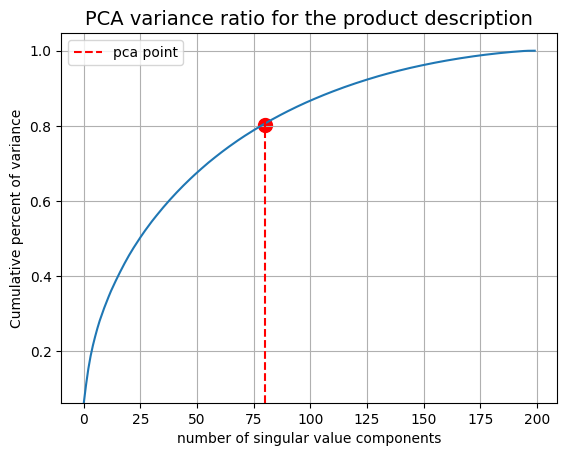

In [733]:
plt.plot(pca.explained_variance_ratio_.cumsum())
ax=plt.gca()
plt.scatter(80, pca.explained_variance_ratio_.cumsum()[80-1], s=100,c='red')
plt.vlines(80,ymin=pca_min, ymax=0.81, colors='red', linestyles='dashed', label='pca point')
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance') 
plt.title('PCA variance ratio for the product description', fontsize=14)
ax.set_ylim(pca_min)
plt.grid()
plt.legend(loc='best')
plt.show();

In [129]:
n_comp=80
df_latent= pd.DataFrame(df_cont[:,0:n_comp], index=df_merged.user_id_joined.tolist())
#df_latent.head()

In [133]:
df_latent.shape

(900, 80)

In [194]:
df_latent.head()

0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48  \
0  0.272798 -0.079222 -0.014242 -0.014489  0.105206 -0.366347  0.387863 -0.171248 -0.289809  0.096253 -0.115312  0.089365 -0.029675  0.082761 -0.089502 -0.072027  0.059059 -0.106144  0.091688 -0.103247 -0.069023  0.040460 -0.112631  0.005842  0.038585 -0.111625 -0.039543  0.127347 -0.023053 -0.000829 -0.013673 -0.016025 -0.087207  0.051343  0.092064  0.042918 -0.107825 -0.030893  0.002072 -0.089695  0.007200  0.074340 -0.070643  0.046389  0.023301  0.063344  0.048333 -0.075047  0.105586   
1  0.364873  0.017757  0.057634 -0.008009  0.004535 -0.019308 -0.106269  0.244446  0.018276  0.047562  0.061823 -0.029638 -0.000805  0.082077 -0.126999  0.148946  0.240452 -0.078818  0.064757  0.074723 -0.133566 -0.087838  0.012811  0.103898  0.012185  0.137768  0.002131 -0.059931  0.003687  0.133603  0.010850 -0.160719 -0.006816 -0.088137  0.207196  0.026090 -0.052713 -0.129529 -0.015328  0.018337 -0.071464  0.020234 -0.113226 -0.007956 -0.162543 -0.141159  0.076074  0.197073 -0.161187   
2  0.194817 -0.030239 -0.050098 -0.039238  0.006604 -0.225355  0.138017 -0.093523 -0.235989 -0.109053 -0.229880 -0.203717 -0.028565 -0.079666 -0.045691  0.108487  0.110114  0.044894  0.131404 -0.139198  0.083712  0.089092 -0.063791 -0.001647  0.003622 -0.269877  0.022359 -0.012432  0.017458  0.092305 -0.060851  0.073927  0.123438 -0.056217 -0.059886 -0.092021  0.013095  0.051522 -0.115635  0.093057 -0.019575  0.005713  0.019384  0.061274  0.034813 -0.099622 -0.013891  0.002094 -0.130820   
3  0.386593  0.132062  0.057339  0.064755 -0.036737  0.040108 -0.023858  0.108156  0.104995 -0.185334 -0.025587  0.096934 -0.182201  0.137541 -0.098605  0.030799  0.007546 -0.141888  0.077235  0.085284 -0.251020  0.065955  0.020435 -0.061536 -0.171308  0.113264  0.016206 -0.023412 -0.021516 -0.213621 -0.159510 -0.112967  0.075323  0.009304 -0.257435  0.079353  0.003515  0.002960 -0.095820  0.042371 -0.019625 -0.109277 -0.052862 -0.065751 -0.010326  0.019694  0.045496 -0.024713  0.052571   
4  0.332280 -0.133511 -0.120831 -0.077724  0.113393 -0.172316  0.085337  0.208681 -0.218175  0.127325  0.085179  0.004381 -0.178039 -0.154354  0.140922 -0.128041  0.090246 -0.145017 -0.052101 -0.172869 -0.070545 -0.149000  0.146946  0.077083  0.166250 -0.061503  0.189127  0.043762 -0.082504 -0.072854 -0.029973  0.033203 -0.035497  0.103151  0.035396 -0.060956 -0.105592 -0.135906 -0.077072 -0.098669 -0.001640 -0.029486  0.134704  0.004081  0.024217  0.031232  0.048338 -0.011469 -0.027345   

         49        50        51        52        53        54        55        56        57        58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79  
0  0.029807  0.044366 -0.003884 -0.055491 -0.082720 -0.037533  0.015108 -0.114369  0.060859 -0.069979 -0.065254  0.064611  0.029145 -0.040310  0.016320  0.004659  0.078172 -0.024082  0.029502  0.029037  0.000795 -0.075482  0.112685 -0.023953 -0.079895  0.023953  0.021046 -0.020460 -0.047365  0.069984  0.018026  
1  0.010192  0.006557 -0.057640  0.000405 -0.016362 -0.046473  0.024020 -0.071070  0.104356  0.014961  0.070963  0.060647  0.132242 -0.020190 -0.104645 -0.052964 -0.108754  0.064124 -0.008763 -0.011837  0.010876 -0.077041  0.004245 -0.026230  0.043908  0.023673 -0.068615 -0.027491  0.028158  0.008298  0.013762  
2 -0.010566  0.071789 -0.092332  0.123576 -0.177315  0.064010 -0.100891  0.003082 -0.107685 -0.0

In [237]:
df_merged[df_merged.duplicated()]

product_name  product_id       brand          main_category sub_category  actual_price  discounted_price  discount_percentage  user_id_joined
420  Portronics Konnect L POR-1081 Fast Charging 3A...  B08CF3D7QR  Portronics  Computers Accessories    USBCables         339.0             154.0                 55.0              10
587  Sounce Fast Phone Charging Cable & Data Sync U...  B096MSW6CT      Sounce  Computers Accessories    USBCables         999.0             199.0                 80.0               2
636  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...  B07DJLFMPS          HP            Electronics      MicroSD           1.6             369.0                 77.0             341
646  MI Braided USB Type-C Cable for Charging Adapt...  B083342NKJ          MI  Computers Accessories    USBCables         399.0             349.0                 13.0              15

In [189]:
df_merged.user_id_joined= df_merged.user_id_joined.factorize()[0]

In [191]:
df_merged.drop(columns=['clean_about_product'], axis=1, inplace=True)

In [ ]:
df_merged.set_index('user_id_joined', inplace=True)

In [207]:
df_merged.reset_index(drop=True, inplace=True)

In [ ]:
df_latent= df_latent.reset_index().rename(columns={'index':'user_id_joined'})

In [220]:
df_cont= df_merged.merge(df_latent, on='user_id_joined', how='outer')

In [222]:
df_cont.set_index(df_cont.user_id_joined, inplace=True)

In [249]:
df_cont.duplicated().sum()

0

In [244]:
df_cont1= df_cont[['product_name','product_id','brand','main_category','sub_category','actual_price','discounted_price','discount_percentage']]
df_cont1.drop_duplicates(inplace=True)

In [250]:
df_cont2= df_cont[[str(i) for i in range(80)]]
df_cont2.drop_duplicates(inplace=True)

In [251]:
print(df_cont1.shape, df_cont2.shape)

(896, 8) (823, 80)


In [266]:
df_cont1.reset_index(inplace=True)
df_cont2.reset_index(inplace=True)

In [289]:
df_cont_merged= df_cont1.merge(df_cont2, on='user_id_joined', how='inner')

In [296]:
df_cont_merged.shape

(1149, 89)

In [297]:
df_cont_filtered= df_cont_merged.drop_duplicates(subset='product_id')

In [309]:
df_cont_filtered.set_index('user_id_joined', inplace=True)

In [229]:
#df_cont.columns= (df_cont.columns).astype(str)

In [312]:
robust_scaler= RobustScaler()
df_cont_scaled= robust_scaler.fit_transform(df_cont_filtered.select_dtypes(include=['float64']))

In [ ]:
df_cont_scaled= pd.DataFrame(df_cont_scaled, index=df_cont_filtered.index)

In [504]:
v1= np.array(df_cont_scaled.iloc[8,:]).reshape(1,-1)
sim1= cosine_similarity(df_cont_scaled,v1).reshape(-1) ## content

In [335]:
df_sim= pd.DataFrame({'sim':sim1}).sort_values(by='sim', ascending=False)

In [336]:
df_sim= df_sim.reset_index().rename(columns={'index':'user_id_joined'})

In [337]:
df_obj= df_cont_filtered.select_dtypes(include= ['object']).reset_index()

In [ ]:
df_sim_merged= df_sim.merge(df_obj, on='user_id_joined')

In [339]:
df_sim_merged.drop_duplicates(subset='sim').head()

user_id_joined       sim                                       product_name  product_id       brand          main_category         sub_category
0               8  1.000000  TP-Link USB WiFi Adapter for PC(TL-WN725N), N1...  B008IFXQFU     TP-Link  Computers Accessories  WirelessUSBAdapters
3               9  0.968575  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...  B082LZGK39     Ambrane  Computers Accessories            USBCables
5              10  0.966521  Portronics Konnect L POR-1081 Fast Charging 3A...  B08CF3D7QR  Portronics  Computers Accessories            USBCables
6             120  0.624134  pTron Solero 331 3.4Amps Multifunction Fast Ch...  B0B4HKH19N       pTron  Computers Accessories            USBCables
9             121  0.624029  10k 8k 4k HDMI Cable, Certified 48Gbps 1ms Ult...  B08TGG316Z         10k            Electronics           HDMICables

### Recommendation -- Collaborative

In [738]:
df= df_recomm_feat1.copy()

In [739]:
rating_feat=['product_id', 'product_name', 'user_id', 'rating', 'rating_count','order_count', 'review_title_content',\
            'brand','main_category','sub_category','brand_count']
df= df[rating_feat]

In [740]:
merged1= pd.DataFrame(df.groupby('product_id')['user_id'].apply(lambda x:'%s' % ' '.join(x)))\
.rename(columns={'user_id':'user_id_joined'})
merged2= pd.DataFrame(df.groupby('product_id')['review_title_content'].apply(lambda x:'%s' % ' '.join(x)))\
.rename(columns={'review_title_content':'review_joined'})

In [741]:
df_merged=df.merge(merged1, on='product_id', how='left').merge(merged2, on='product_id', how='right')

In [742]:
df_merged.drop(columns=['user_id', 'review_title_content'], inplace=True)

In [743]:
df_merged.duplicated().sum()

6939

In [744]:
df_merged.drop_duplicates(inplace=True)

<AxesSubplot:>

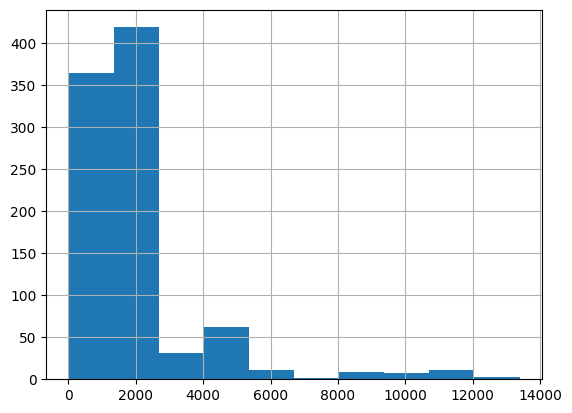

In [442]:
df_merged.review_joined.apply(lambda x:len(x)).hist()

In [745]:
df_merged.reset_index(drop=True, inplace=True)

In [448]:
df_merged.shape

(919, 11)

In [746]:
#count= CountVectorizer(stop_words='english', max_features=100)
count= TfidfVectorizer(max_features=2500, max_df=0.75, ngram_range=(1,2),norm='l2')
df_count= count.fit_transform(df_merged['review_joined'])

In [747]:
df_vector_prod= pd.DataFrame(df_count.toarray(), index= df_merged.index.tolist())

In [748]:
df_vector_prod.shape

(919, 2500)

In [472]:
df_vector_prod.duplicated().sum()

27

In [749]:
#svd= TruncatedSVD()
pca= PCA(n_components=350)
df_cont= pca.fit_transform(df_vector_prod)

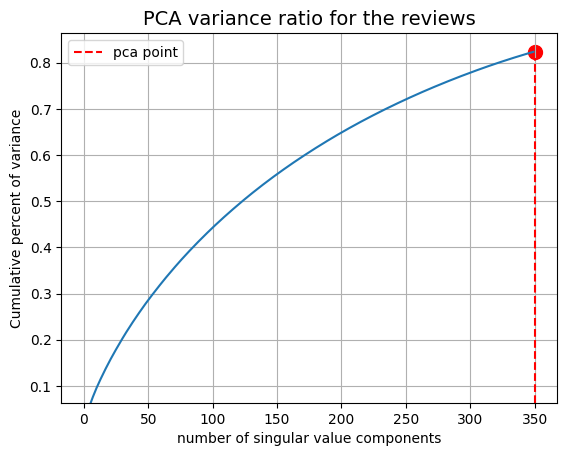

In [750]:
plt.plot(pca.explained_variance_ratio_.cumsum())
ax=plt.gca()
plt.scatter(350, pca.explained_variance_ratio_.cumsum()[350-1], s=100,c='red')
plt.vlines(350,ymin=pca_min, ymax=0.81, colors='red', linestyles='dashed', label='pca point')
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance') 
plt.title('PCA variance ratio for the reviews', fontsize=14)
ax.set_ylim(pca_min)
plt.grid()
plt.legend(loc='best')
plt.show();

In [ ]:
n_comp=350
df_latent= pd.DataFrame(df_cont[:,0:n_comp], index=df_merged.user_id_joined.tolist())

In [458]:
df_latent.index= df_latent.index.factorize()[0]

In [573]:
df_latent.head()

0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48   \
0 -0.120313 -0.201904 -0.290572 -0.080467 -0.117990  0.225504  0.301520  0.241954  0.062316 -0.089483  0.033189  0.103181  0.010965  0.148766 -0.092972 -0.119921  0.102444 -0.017049  0.012215 -0.010643  0.018312 -0.026629 -0.040908  0.061129  0.000530  0.045792  0.035265 -0.065041  0.008259 -0.014578 -0.059337  0.019675  0.012327  0.051608 -0.009804  0.014552 -0.002216  0.004649 -0.094158  0.037175  0.020263 -0.053088  0.028983  0.012835 -0.028116 -0.061171  0.010844 -0.003508  0.025132   
1 -0.077776 -0.034082 -0.041562 -0.005728  0.007074 -0.048333 -0.013196 -0.009263 -0.037781 -0.017150 -0.056929  0.006492 -0.049842 -0.046482  0.120988 -0.091363  0.013112 -0.012695 -0.033304 -0.025115  0.037136  0.014653 -0.056348 -0.125840  0.027654  0.028469 -0.037609  0.065579  0.130654  0.185742  0.044757 -0.105289 -0.098930  0.058822 -0.111687 -0.066791 -0.018872 -0.037449 -0.086094  0.132311 -0.083176 -0.021496  0.096499  0.036710  0.002070  0.053971 -0.063176  0.013031 -0.091228   
2 -0.068815 -0.069834  0.025470  0.078840 -0.127313 -0.174999 -0.180949  0.176940 -0.075961  0.001143  0.066628  0.237086  0.046332  0.032339  0.022962  0.039803  0.018352  0.038427 -0.028582  0.044143  0.055209  0.001014 -0.059224 -0.004260  0.018720  0.035394  0.026580 -0.017541  0.005866  0.040348 -0.054217 -0.048959  0.052366 -0.076441 -0.051052  0.023801  0.009704  0.060880  0.087199  0.028473  0.026777  0.019513  0.003952 -0.034770 -0.038580 -0.084003 -0.019658  0.084752  0.056475   
3 -0.045429 -0.028818  0.068273  0.021624 -0.072602 -0.047834 -0.054432  0.059506  0.009521 -0.024776  0.030164 -0.041375 -0.050511  0.020519  0.065471 -0.028996  0.057910  0.066842 -0.080040 -0.104641  0.047374  0.004874  0.036890 -0.071142 -0.021934  0.121791  0.030982  0.068783  0.018096  0.071790  0.029961  0.064169 -0.074207  0.088920  0.026838 -0.059197  0.039859 -0.071912 -0.044016  0.043827 -0.063939 -0.035912  0.010731  0.001602 -0.024721  0.091464  0.047603 -0.045786  0.110691   
4 -0.062977  0.097312  0.022665  0.056256 -0.075597 -0.183020  0.096453  0.150266 -0.081866  0.022999 -0.071812 -0.001969  0.046466 -0.023113  0.055762  0.041589  0.019895  0.043824 -0.063581  0.068461 -0.061477  0.015919 -0.022992  0.014528  0.036058  0.117824 -0.003047  0.084302  0.027853  0.031548 -0.026278  0.109888  0.063718 -0.022668  0.041292  0.106033  0.035439  0.078232 -0.077038  0.020781 -0.059121  0.047134 -0.014951  0.002282 -0.003001 -0.054053 -0.037676  0.002040  0.011117   

        49        50        51        52        53        54        55        56        57        58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88        89        90        91        92        93        94        95        96        97   \
0  0.004563  0.010935 -0.020909  0.033124 -0.058724  0.016495  0.046749 -0.006367  0.019237  0.004136  0.049459 -0.010987 -0.018322  0.016924 -0.071498 -0.010987  0.060587  0.026964  0.019554 -0.031325 -0.027561  0.065214  0.023085  0.012871  0.033604 -0.008165 -0.013651  0.039875 -0.031426  0.009546 -0.010905 -0.006215 -0.012724 -0.001804 -0.021866  0.018895 -0.005163 -0.029308  0.021663  0.059470 -0.020319 -0.005089  0.039629  0.009887  0.028695 -0.051090  0.016685 -0.014270 -0.007697   
1 -0.087604  0.048054 -0.012344  0.082010  0.02

In [467]:
df_merged.user_id_joined= df_merged.user_id_joined.factorize()[0]

In [466]:
df_merged.drop(columns=['review_joined'], inplace=True)

In [475]:
df_latent1= df_latent.reset_index().rename(columns={'index':'user_id_joined'})

In [478]:
df_merged_num= df_merged.select_dtypes(include=np.number)

In [751]:
#df_latent1[df_latent1.duplicated()]

In [480]:
print(df_latent1.shape, df_merged_num.shape)

(919, 351) (919, 5)


In [490]:
df= df_latent1.merge(df_merged_num, on='user_id_joined', how='inner')

In [493]:
df.columns= df.columns.astype(str)

In [ ]:
df.set_index('user_id_joined', inplace=True)

In [497]:
robust_scaler= RobustScaler()
df_scaled= robust_scaler.fit_transform(df)

In [ ]:
df_scaled= pd.DataFrame(df_scaled, index=df.index)

In [517]:
v2= np.array(df_scaled.iloc[8,:]).reshape(1,-1)
sim2= cosine_similarity(df_scaled,v2).reshape(-1) ## content

In [521]:
df_sim2= pd.DataFrame({'collab':sim2}).sort_values(by='collab', ascending=False)
df_sim2= df_sim2.reset_index().rename(columns={'index':'user_id_joined'})

In [ ]:
df_merged.set_index('user_id_joined', inplace=True)

In [1]:
#df_obj2= df_merged.select_dtypes(include= ['object']).reset_index()

In [ ]:
df_collab_merged= df_sim2.merge(df_obj2, on='user_id_joined')

In [2]:
#df_collab_merged.drop_duplicates(subset='collab').head()

In [587]:
def recommender(df1, df2, df3, user_id):
    v1= np.array(df1.iloc[user_id,:]).reshape(1,-1)
    v2= np.array(df2.iloc[user_id,:]).reshape(1,-1)
    sim1= cosine_similarity(df1,v1).reshape(-1) ## content
    sim2= cosine_similarity(df2,v2).reshape(-1) ## collab
    
    df_sim1= pd.DataFrame({'content':sim1}).sort_values(by='content', ascending=False)
    df_sim2= pd.DataFrame({'collab':sim2}).sort_values(by='collab', ascending=False)
    
    df_sim1= df_sim1.reset_index().rename(columns={'index':'user_id_joined'})
    df_sim2= df_sim2.reset_index().rename(columns={'index':'user_id_joined'})
    
    #df3.set_index('user_id_joined', inplace=True)
    #df_obj1= df3.select_dtypes(include= ['object']).reset_index()
    df_merged1= df_sim1.merge(df_obj2, on='user_id_joined')
    df_recom= df_sim2.merge(df_merged1, on='user_id_joined')
    df_recom['hybrid']= (df_recom['content'] + df_recom['collab'])/2.0
    df_recom.drop_duplicates(subset='product_name', inplace=True)
    df_recom= df_recom.sort_values(by='hybrid', ascending=False)
    temp= df_recom.pop('hybrid')
    df_recom.insert(3, 'hybrid',temp)
    return df_recom.reset_index(drop=True)

In [ ]:
user_id= np.random.randint(0,len(set(df_merged.index)))
df= recommender(df_cont_scaled, df_scaled, df_merged, user_id)

In [588]:
df.head()

user_id_joined    collab   content    hybrid  product_id                                       product_name         brand          main_category    sub_category
0              54  1.000000  1.000000  1.000000  B00NNQMYNE  AirCase Rugged Hard Drive Case for 2.5-inch We...       AirCase  Computers Accessories    HardDiskBags
1              97 -0.000497  0.747086  0.373295  B01GGKZ0V6  AmazonBasics USB Type-C to USB Type-C 2.0 Cabl...  AmazonBasics  Computers Accessories       USBCables
2              98 -0.027912  0.745005  0.358546  B01GGKZ4NU  AmazonBasics USB Type-C to USB Type-C 2.0 Cabl...  AmazonBasics  Computers Accessories       USBCables
3              23  0.057987  0.568764  0.313375  B00GG59HU2  BlueRigger High Speed HDMI Cable with Ethernet...    BlueRigger            Electronics      HDMICables
4              90  0.022662  0.584345  0.303503  B01DGVKBC6  FEDUS Cat6 Ethernet Cable, 10 Meter High Speed...         FEDUS  Computers Accessories  EthernetCables